In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from stop_words import get_stop_words
import calendar
import datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn import preprocessing
from sklearn.utils import class_weight
import eli5
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score

Using TensorFlow backend.


In [2]:
train_data=pd.read_csv("Property Datasets/Upsampled_train_data/Train_Up_data.csv")
test_data1=pd.read_csv("Property Datasets/Simple_Data/Test_data_property.csv")
val_data=pd.read_csv("Property Datasets/Simple_Data/Val_data_property.csv")
test_data=pd.concat([test_data1,val_data],axis=0)
test_data.reset_index(drop=True,inplace=True)
print(test_data.shape)

(1301, 2)


<AxesSubplot:>

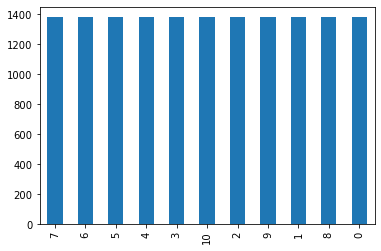

In [3]:
train_data["Label"].value_counts().plot(kind = 'bar')

In [4]:
x=train_data.Text
y=train_data['Label']
x1=test_data.Text
y1=test_data['Label']

###### Preprocessing Data ######

In [5]:
def Preprocessing(x):
    import datetime
    # Month name from number
    month_num = 1
    month_abre = datetime.date(2015, month_num, 1).strftime('%b')
    month_name = datetime.date(2015, month_num, 1).strftime('%B')

    # Print list of all months from calendar
    month_abr=[]
    month=[]
    for month_val in range(1, 13):
        month_abr.append(calendar.month_abbr[month_val])
        month.append(calendar.month_name[month_val])
    month_abrev=[word.lower() for word in month_abr ] 
    months=[word.lower() for word in month ]
    months.extend(month_abrev)

    stop_words = (list(
        set(get_stop_words('en'))
        |set(months)
    ))
    stop_words.extend(["claim",'id','dopa',"arise","claimant","allegations","auto","ploicy","care","work","potential",
                        "service","allegdly","allege","clmt","insd",'insure','incident','covid-19','covid','complaint',
                      'ovid','state','district','plaintiff','instal','due','demand','locate',
                        'cause','client','customer','date','understand','app'])


    REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    def preprocess_reviews(reviews):
        reviews= [line.lower() for line in reviews]
        reviews = [str (item) for item in reviews]
        reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
        reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
        return reviews
    reviews_train_clean = preprocess_reviews(x)
    
    def get_lemmatized_text(corpus):
        from nltk.stem import WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        return [' '.join([lemmatizer.lemmatize(word,'v') for word in review.split()]) for review in corpus]
    reviews_train_clean = get_lemmatized_text(reviews_train_clean)  
        
    only_alpha=[]
    for i in reviews_train_clean:
        s=re.sub("[^A-Za-z]"," ",str(i))
        s=re.sub("  +"," ",s)
        s = re.sub(r"\bprop\b","property",s)
        s = re.sub(r"\bcvg\b","coverage",s)
        s = re.sub(r'\d',' ', s)
        only_alpha.append(s)
        
    def remove_stop_words(corpus):
        removed_stop_words = []
        for review in corpus:
            removed_stop_words.append(
                ' '.join([word for word in review.split()
                          if word not in stop_words])
            )
        return removed_stop_words
    after_sw = remove_stop_words(only_alpha)
    return(after_sw)

In [6]:
x_train=Preprocessing(x)
x_test=Preprocessing(x1)
print(len(x_test),len(x_train))
y_train=np.array(y)
y_test=np.array(y1)
print(len(y_test),len(y_train))

1301 15202
1301 15202


In [7]:
def count_vec(a,b):
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer.fit(x_train)
    a = count_vectorizer.transform(a).toarray()
    b = count_vectorizer.transform(b).toarray()
    return a,b

def ngram_count_vec(a,b):
    count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2))
    count_vectorizer.fit(x_train)
    a = count_vectorizer.transform(a).toarray()
    b = count_vectorizer.transform(b).toarray()
    return a,b

def tfidf_vec(a,b):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_vectorizer.fit(x_train)
    a = tfidf_vectorizer.transform(a).toarray()
    b = tfidf_vectorizer.transform(b).toarray()
    return a,b

def ngram_tfidf_vec(a,b):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
    tfidf_vectorizer.fit(x_train)
    a = tfidf_vectorizer.transform(a).toarray()
    b = tfidf_vectorizer.transform(b).toarray()
    return a,b

###### Naive_Bayes ########

In [8]:
V = [tfidf_vec , ngram_tfidf_vec, count_vec , ngram_count_vec]
B = ['tfidf_vec' , 'ngram_tfidf_vec', 'count_vec' , 'ngram_count_vec']

num_of_funcs = len(V)
vector = []
accuracy = []
f1=[]
recall=[]
precision=[]
f1_all=[]
recall_all=[]
precision_all=[]
for i,j in zip(range(num_of_funcs),B):
    xtrain_vec, xtest_vec = V[i % num_of_funcs](x_train, x_test)
    model = MultinomialNB().fit(xtrain_vec, y_train)
    y_pred = model.predict(xtest_vec)
    acc_score=accuracy_score(y_test,y_pred)
    f1.append(f1_score(y_test,y_pred,average='macro'))
    recall.append(recall_score(y_test,y_pred,average='macro'))
    precision.append(precision_score(y_test,y_pred,average='macro'))
    accuracy.append(acc_score)
    f1_all.append(f1_score(y_test,y_pred,average=None))
    recall_all.append(recall_score(y_test,y_pred,average=None))
    precision_all.append(precision_score(y_test,y_pred,average=None))
    vector.append(j)
    print("NaiveBayes-"+j,acc_score*100)


NaiveBayes-tfidf_vec 78.55495772482706
NaiveBayes-ngram_tfidf_vec 78.63182167563413
NaiveBayes-count_vec 78.09377401998464
NaiveBayes-ngram_count_vec 76.94081475787856


In [9]:
df1 = pd.DataFrame(vector)
df2 = pd.DataFrame([accuracy,f1,precision,recall])

df = pd.concat([df1, df2], ignore_index=True, sort=False, axis =1)
df.columns = ['Naive_Bayes', 'Accuracy',"F1-score","Precision","Recall"]
df

,Naive_Bayes,Accuracy,F1-score,Precision,Recall
0,tfidf_vec,0.785550,0.786318,0.780938,0.769408
1,ngram_tfidf_vec,0.696889,0.703816,0.690285,0.668454
2,count_vec,0.663773,0.671517,0.669312,0.647722
3,ngram_count_vec,0.757184,0.762428,0.738430,0.717796


In [10]:
pd.DataFrame(recall_all)

,0,1,2,3,4,5,6,7,8,9,10
0,0.863636,0.956522,0.771605,0.529412,0.431818,0.941176,0.640152,0.946565,0.578947,0.815385,0.853801
1,0.818182,1.000000,0.765432,0.558824,0.454545,0.941176,0.643939,0.938931,0.578947,0.815385,0.871345
2,0.795455,0.956522,0.787037,0.470588,0.409091,0.882353,0.670455,0.954198,0.578947,0.846154,0.771930
3,0.772727,0.956522,0.771605,0.500000,0.386364,0.901961,0.651515,0.950382,0.421053,0.800000,0.783626


###### SVM-SVC #######

In [11]:
V = [tfidf_vec , ngram_tfidf_vec, count_vec , ngram_count_vec]
B = ['tfidf_vec' , 'ngram_tfidf_vec', 'count_vec' , 'ngram_count_vec']

num_of_funcs = len(V)
vector = []
accuracy = []
f1=[]
recall=[]
precision=[]
f1_all=[]
recall_all=[]
precision_all=[]
for i,j in zip(range(num_of_funcs),B):
    xtrain_vec, xtest_vec = V[i % num_of_funcs](x_train, x_test)
    svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)
    model = svm.fit(xtrain_vec, y_train)
    y_pred = model.predict(xtest_vec)
    acc_score=accuracy_score(y_test,y_pred)
    f1.append(f1_score(y_test,y_pred,average='macro'))
    recall.append(recall_score(y_test,y_pred,average='macro'))
    precision.append(precision_score(y_test,y_pred,average='macro'))
    accuracy.append(acc_score)
    f1_all.append(f1_score(y_test,y_pred,average=None))
    recall_all.append(recall_score(y_test,y_pred,average=None))
    precision_all.append(precision_score(y_test,y_pred,average=None))
    vector.append(j)
    print("SVM-"+j,acc_score*100)

SVM-tfidf_vec 84.0891621829362
SVM-ngram_tfidf_vec 85.62644119907763
SVM-count_vec 84.6272098385857
SVM-ngram_count_vec 86.01076095311299


In [ ]:
df1 = pd.DataFrame(vector)
df2 = pd.DataFrame([accuracy,f1,precision,recall])

df = pd.concat([df1, df2], ignore_index=True, sort=False, axis =1)
df.columns = ['Naive_Bayes', 'Accuracy',"F1-score","Precision","Recall"]
df

In [218]:
pd.DataFrame(recall_all)

,0,1,2,3,4,5,6,7,8,9,10
0,0.818182,0.956522,0.799383,0.529412,0.522727,0.941176,0.791667,0.961832,0.631579,0.876923,0.923977
1,0.818182,0.956522,0.817901,0.558824,0.545455,0.960784,0.818182,0.961832,0.578947,0.892308,0.947368
2,0.795455,0.869565,0.824074,0.529412,0.454545,0.901961,0.818182,0.961832,0.631579,0.830769,0.941520
3,0.727273,0.869565,0.851852,0.441176,0.545455,0.921569,0.863636,0.961832,0.578947,0.800000,0.947368
